In [1]:
from pauli import PauliSum, SiteBasis, PauliString
from hamiltonians import transverse_field_ising_model

import picos as pc
import numpy as np
from scipy.sparse import csr_array
import matplotlib.pyplot as plt

<h2>Thermal Transverse Field Ising:</h2>

In [2]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def beta_independent_constraints(basis: SiteBasis, B: pc.RealVariable, L: int, hamil: PauliSum):
    constraints = [B[basis.rank('I' * L)] == 1.0]
    row_ind, col_ind, data = [], [], []
    n_rows = 0
    n_cols = B.shape[0]
    for word in basis._ops:
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            row_ind.append(n_rows)
            col_ind.append(basis.rank(str(pstr)))
            data.append(np.imag(weight))
        n_rows += 1
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), shape=(n_rows, n_cols)).toarray()
        constraints.append(P * B == 0)
    ops = basis._ops
    n = len(ops)
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliString(ops[i])
            pj = PauliString(ops[j])
            pstr = pi * pj
            idx = basis.rank(str(pstr))
            row_inds[idx].append(i)
            col_inds[idx].append(j)
            datas[idx].append(pi.phase(pj))
    A = pc.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)).toarray() * B[i] for i in range(n)])
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliSum(ops[i])
            pj = PauliSum(ops[j])
            psum = pi * (hamil | pj)
            if psum.is_zero():
                continue
            # Now, we have a PauliSum of terms...and also some zero locations
            # Experiments suggest that the sparsity is not much
            # Now each non-zero location is some linear combination of Pauli strings
            # in the reduced basis...how to deal with this?
            # Well, now it is a linear matrix inequality...just write as F[i] * x[i]
            # These F[i] are sparse
            for pstr, weight in psum.terms.items():
                idx = basis.rank(str(pstr))
                row_inds[idx].append(i)
                col_inds[idx].append(j)
                datas[idx].append(weight)
    C = pc.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)).toarray() * B[i] for i in range(n)])
    return constraints, A, C

def beta_dependent_kms(beta, A, C):
    return beta * C >> pc.oprelentr(A, A.T)

In [8]:
def construct_problem(L: int, h: float):
    basis = SiteBasis(L, True)
    B = pc.RealVariable('B', basis.size())
    hamil = transverse_field_ising_model(L, h)
    prob = pc.Problem()
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    constraints, A, C = beta_independent_constraints(basis, B, L, hamil)
    prob.add_list_of_constraints(constraints)
    return prob, energy, A, C

def solve_energy(betas, prob: pc.Problem, energy, A, C):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, beta in enumerate(betas):
        kmscons = beta_dependent_kms(beta, A, C)
        prob.add_constraint(kmscons)
        print(f'Solving for T={1/beta}, i={i}:')
        prob.set_objective("min", energy)
        E_min = prob.solve(solver='qics').value
        prob.set_objective("max", energy)
        E_max = prob.solve(solver='qics').value
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
        prob.remove_constraint(kmscons)
    return mins, maxs

In [ ]:
L, h = 4, 1
prob, energy, A, C = construct_problem(L, h)

In [14]:
betas = 1/np.linspace(0.1, 4, num = 20)
mins, maxs = solve_energy(betas, prob, energy, A, C)

Solving for T=0.1, i=0:


c:\mtp\my-work\.venv\Lib\site-packages\picos\expressions\exp_oprelentr.py:140: RuntimeWarning: invalid value encountered in sqrt
  rtX = Ux @ numpy.diag(numpy.sqrt(Dx)) @ Ux.conj().T


	E_min = -5.2189419852348475
	E_max = -5.218941606503808
Solving for T=0.30526315789473685, i=1:


c:\mtp\my-work\.venv\Lib\site-packages\picos\expressions\exp_oprelentr.py:145: RuntimeWarning: invalid value encountered in log
  logXYX = Uxyx @ numpy.diag(numpy.log(Dxyx)) @ Uxyx.conj().T


	E_min = -5.141111524034285
	E_max = -5.140756306560351
Solving for T=0.5105263157894737, i=2:
	E_min = -5.090160781016913
	E_max = -5.080649120925444
Solving for T=0.7157894736842105, i=3:
	E_min = -5.009867288490815
	E_max = -4.977755995699989
Solving for T=0.9210526315789475, i=4:


KeyboardInterrupt: 

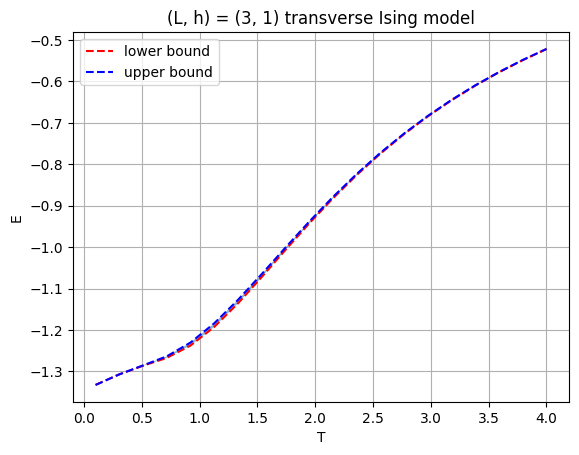

In [12]:
plt.fill_between(1/betas, mins / L, maxs / L, alpha = 0.5, zorder=2)
plt.plot(1/betas, mins / L,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs / L,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h) = ({L}, {h}) transverse Ising model')
plt.legend()
plt.grid(zorder=1)
plt.savefig(f'ising-{L}-{h}.png',bbox_inches='tight')
plt.show()